In [217]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from skimage.io import imread
from skimage.transform import resize
from skimage import color, feature, exposure

In [143]:
data_dir = 'cell_images/'

In [145]:
# Function to extract HOG features from an image and visualize it
def extract_hog_features(image):
    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)

    # Calculate HOG features
    hog_features, hog_image = feature.hog(gray_image, visualize=True)

    # Enhance the contrast of the HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return hog_features, hog_image_rescaled

In [144]:
flattened_data = []
images = []
target = []
categories = ['Uninfected', 'Parasitized']
num_images_per_class = 1000

In [149]:
for category in categories:
    class_number = categories.index(category)
    path = os.path.join(data_dir, category)
    all_images = os.listdir(path)
    selected_images = np.random.choice(all_images, num_images_per_class, replace=True)
    for image_name in selected_images:
        image_array = imread(os.path.join(path, image_name))
        image_resized = resize(image_array, (150, 150, 3))
        hog_features, hog_image = extract_hog_features(image_resized)
        flattened_data.append(hog_features.flatten())
        images.append(image_resized)
        target.append(class_number)

In [150]:
flatten_data = np.array(flattened_data)
del flattened_data
images_ = np.array(images)
del images
target_ = np.array(target)
del target

In [151]:
X_train, X_test, y_train, y_test = train_test_split(flatten_data, target_, random_state=1111, test_size = 0.2)

In [184]:
log_reg = LogisticRegression(C = 0.01, max_iter = 1000, warm_start=False)

In [133]:
max_iter = range(100, 500)
solver = ['newton-cg', 'liblinear']
warm_start = [True, False]
C = np.arange(0.01, 1, 0.01)
random_grid = {
    'max_iter' : max_iter,
    'warm_start' : warm_start,
    'solver' : solver,
    'C' : C,
}

In [ ]:
random_estimator = RandomizedSearchCV(estimator = log_reg,
                                   param_distributions = random_grid,
                                   random_state = 1111,
                                    error_score = 'raise',
                                  )

random_estimator.fit(X_train, y_train)

In [186]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=1000)

In [154]:
y_pred = log_reg.predict(X_test)

In [157]:
test_image_path = 'D:/C83P44ThinF_IMG_20150817_140045_cell_144.png'

In [158]:
image = imread(test_image_path)

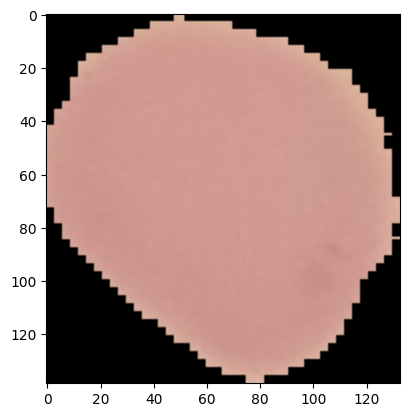

In [159]:
plt.imshow(image)

In [160]:
resized_image = resize(image, (150, 150, 3))

In [163]:
hog_features, hog_image = extract_hog_features(resized_image)

In [ ]:
#Just testing on a cell image sample.

In [169]:
X = hog_features.flatten().reshape(1, -1)

In [170]:
log_reg.predict(X)

array([0])

In [201]:
#Confusion Matrix:
cm = confusion_matrix(y_test, y_pred)

#Accuracy:
accuracy = log_reg.score(X_test, y_test)

#Cross validation:
cvs = cross_val_score(log_reg, flatten_data, target_, cv=5)

In [202]:
#Possible C values:
C_values = [0.1, 1, 10, 100]
accuracies = []
for C in C_values:
    log_reg.C = C
    scores = cross_val_score(log_reg, flatten_data, target_, cv=5)  # 5-fold cross-validation
    accuracies.append(scores.mean())

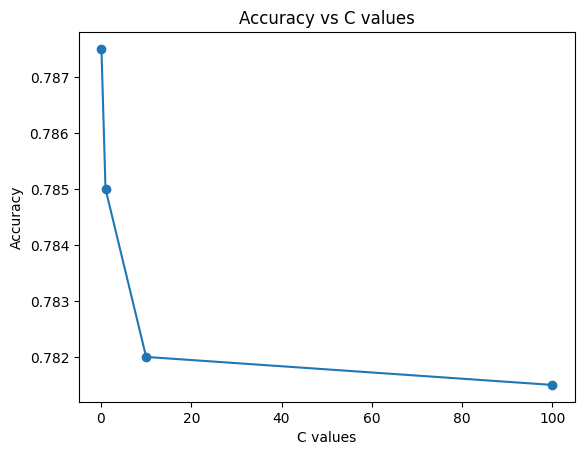

In [203]:
plt.plot(C_values, accuracies, marker='o')
plt.xlabel('C values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C values')
plt.show()

In [207]:
print(f'Confusion Matrix: {cm}\n')
print(f'Accuracy: {accuracy}')
print(f'Cross Validation Score: {cvs.mean()}')

Confusion Matrix: [[166  33]
 [ 58 143]]

Accuracy: 0.7725
Cross Validation Score: 0.766


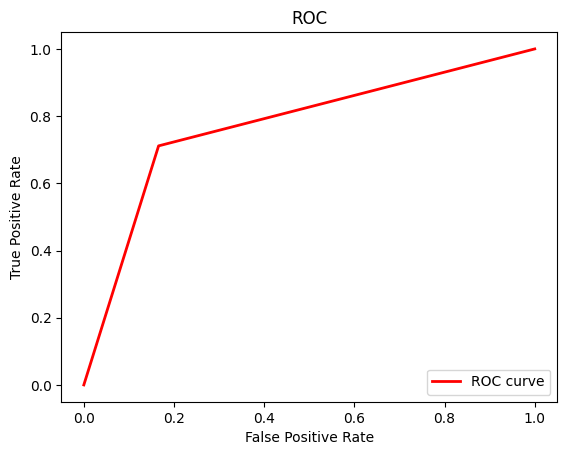

In [205]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

In [267]:
#Using Kmeans Model
n_clusters = 2  # Number of clusters (0 through 9 digits)
kmeans = KMeans(n_clusters=2, random_state=1111, algorithm='auto', n_init=10)
kmeans.fit(X_train)

KMeans(n_clusters=2, n_init=10, random_state=1111)

In [268]:
y_pred = kmeans.predict(X_test)

In [272]:
#Confusion Matrix:
cm = confusion_matrix(y_test, y_pred)

distance = kmeans.inertia_

#Cross validation:
cvs = cross_val_score(kmeans, flatten_data, target_, cv=5)

In [273]:
print(f'Confusion Matrix: {cm}\n')
print(f'Sum of squared distances: {distance}')
print(f'Cross Validation Score: {cvs.mean()}')

Confusion Matrix: [[ 61 138]
 [ 92 109]]

Sum of squared distances: 163806.59791209886
Cross Validation Score: -40930.20011830372


In [275]:
print('KMeans Train Score is : ' , kmeans.score(X_train))
print('KMeans Test Score is : ' , kmeans.score(X_test))

KMeans Train Score is :  -163806.59791209883
KMeans Test Score is :  -40158.23297434318


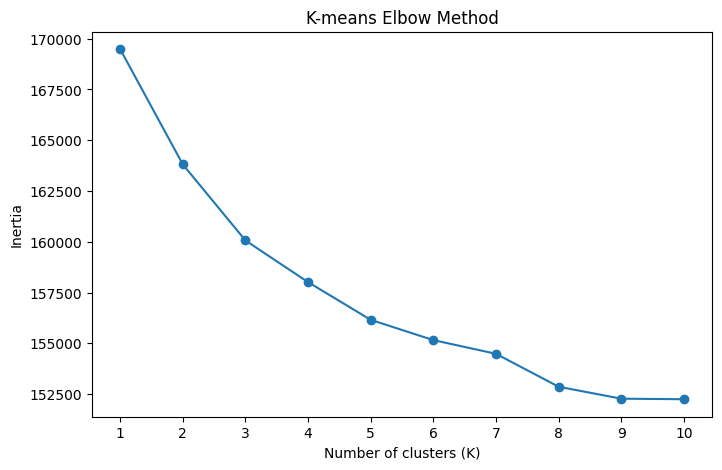

In [278]:
# Define a range of K values for KMeans
k_values = range(1, 11)  # You can adjust this range based on your problem

# Initialize an empty list to store inertia values
inertia_values = []

# Iterate through different K values and fit KMeans, collecting inertia values
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1111, n_init='auto')
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)

# Plot the "loss curve" (inertia values)
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('K-means Elbow Method')
plt.xticks(k_values)
plt.show()